### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3
SSIDno = 9090786

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 7 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(12986, 12)

time: 160 ms


In [5]:
ssid_df.memory_usage(deep=True)

Index                   80
Day                 834207
DestStopID          103888
HourFrame           103888
JourneyPatternID    656228
Rain                103888
SSID                224428
SchoolHoliday        12986
SourceStopID        103888
TimeFrame           870062
TravelTime          103888
VehicleJourneyID    103888
WindSpeed           103888
dtype: int64

time: 8 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 10 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 14 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(12986, 14)

time: 19 ms


In [9]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

time: 1e+03 µs


In [10]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 4 ms


In [11]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 17 ms


In [12]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 4 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,78,0.000000,15.0,57,0,0,Tuesday,8
1,82,0.000000,15.0,57,0,0,Tuesday,8
2,57,0.000000,15.0,57,0,0,Tuesday,8
3,59,0.000000,15.5,57,0,0,Tuesday,9
4,39,0.033333,14.5,57,0,0,Tuesday,7
5,101,0.000000,14.5,57,0,0,Wednesday,8
6,98,0.000000,14.5,57,0,0,Wednesday,8
7,62,0.000000,14.5,57,0,0,Wednesday,8
8,121,0.000000,15.0,57,0,0,Wednesday,9
9,60,0.000000,14.0,57,0,0,Wednesday,7


time: 24 ms


In [14]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 32 ms


In [15]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 10 ms


In [16]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,78,0.000000,15.0,57,0,0,Tuesday,8
1,82,0.000000,15.0,57,0,0,Tuesday,8
2,57,0.000000,15.0,57,0,0,Tuesday,8
3,59,0.000000,15.5,57,0,0,Tuesday,9
4,39,0.033333,14.5,57,0,0,Tuesday,7
5,101,0.000000,14.5,57,0,0,Wednesday,8
6,98,0.000000,14.5,57,0,0,Wednesday,8
7,62,0.000000,14.5,57,0,0,Wednesday,8
8,121,0.000000,15.0,57,0,0,Wednesday,9
9,60,0.000000,14.0,57,0,0,Wednesday,7


time: 26 ms


In [17]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 70 ms


## 1c. Dropping Outliers

Visualising range of data first

Histiogram of values (x-axis is number of seconds)

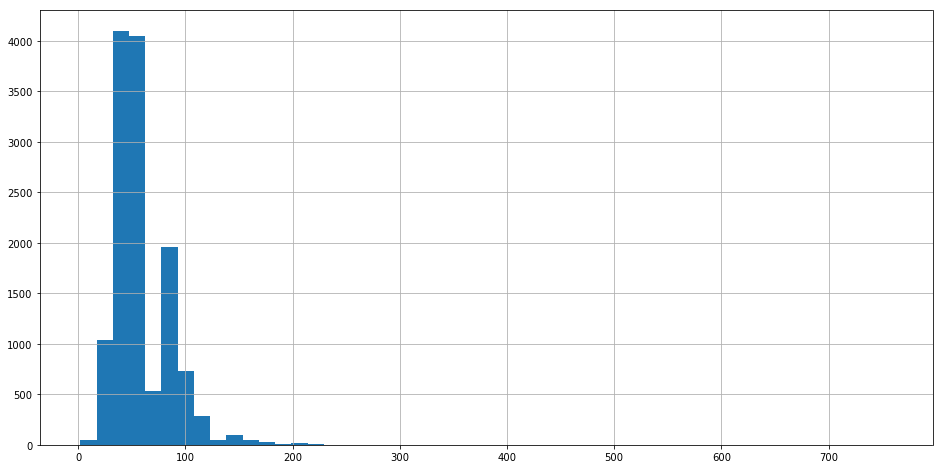

time: 229 ms


In [18]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

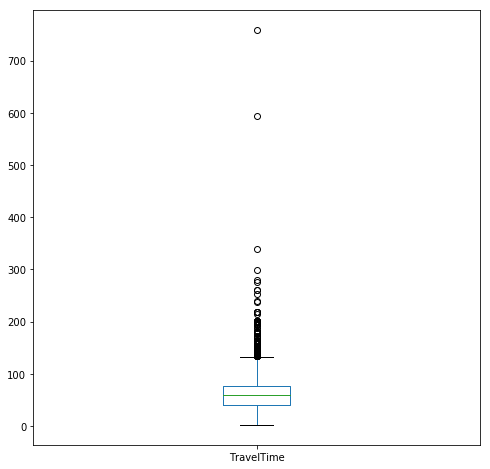

time: 181 ms


In [19]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [20]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    12986.000000
mean        59.226706
std         27.661573
min          2.000000
25%         40.000000
50%         59.000000
75%         77.000000
max        759.000000
Name: TravelTime, dtype: float64

time: 7 ms


Dropping outliers

In [21]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

14.5378563877
time: 11 ms


In [22]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond a conservative 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 57 outliers dropped.
time: 14 ms


In [23]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,188,0.666667,18.0,45,1,0,Friday,17
1,183,0.000000,14.5,71,0,0,Monday,17
2,183,1.866211,21.5,63,0,0,Friday,9
3,181,0.000000,17.5,71,0,0,Tuesday,12
4,181,0.600098,21.5,63,0,0,Friday,11
5,181,0.000000,6.0,63,0,0,Wednesday,18
6,181,1.533203,18.5,64,0,0,Friday,16
7,180,0.366699,5.0,64,0,0,Wednesday,18
8,180,0.000000,6.0,64,0,1,Friday,21
9,180,1.033203,22.0,71,0,0,Friday,15


time: 65 ms


In [24]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    12929.000000
mean        58.774383
std         25.120712
min         15.000000
25%         40.000000
50%         59.000000
75%         77.000000
max        188.000000
Name: TravelTime, dtype: float64

time: 7 ms


Bocplot post-outlier dropping

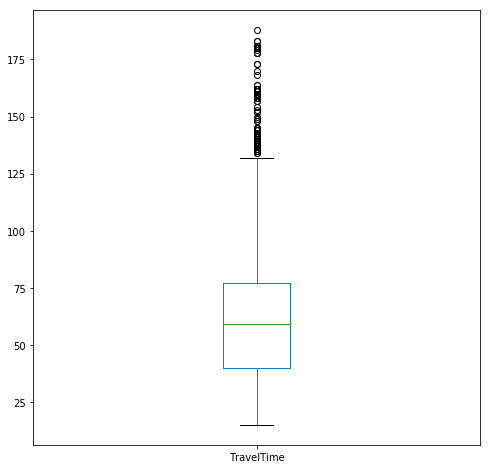

time: 178 ms


In [25]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

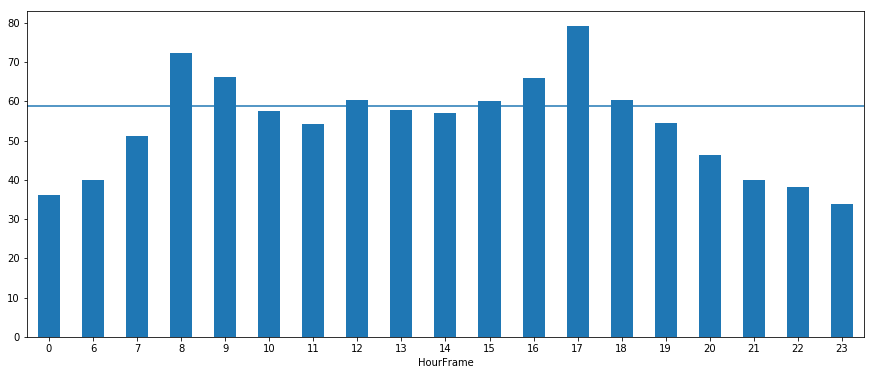

time: 186 ms


In [26]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

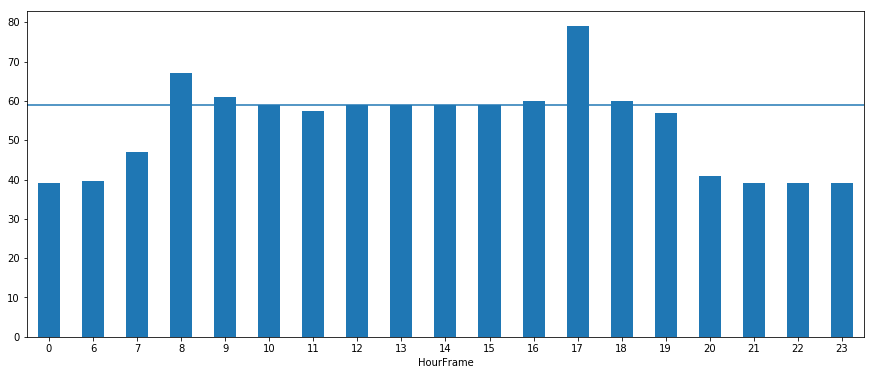

time: 188 ms


In [27]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  Busy at rush-hour, especially the evening.  At or above median most of the day, drops off after 7pm and up until 7am.

### 2bi Bar plot for mean TravelTime per Day

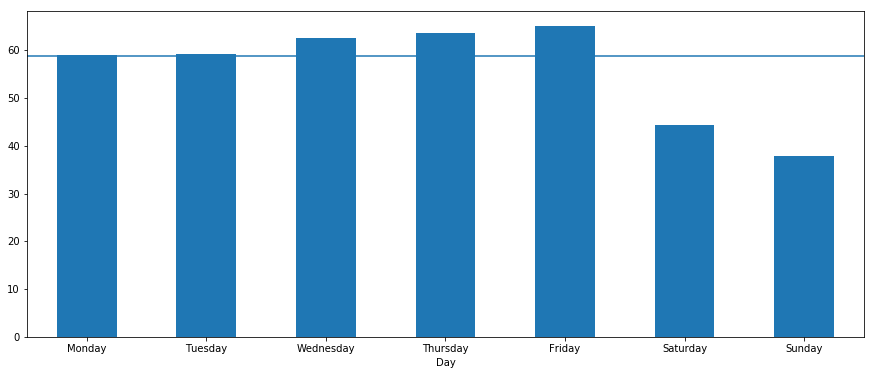

time: 140 ms


In [28]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

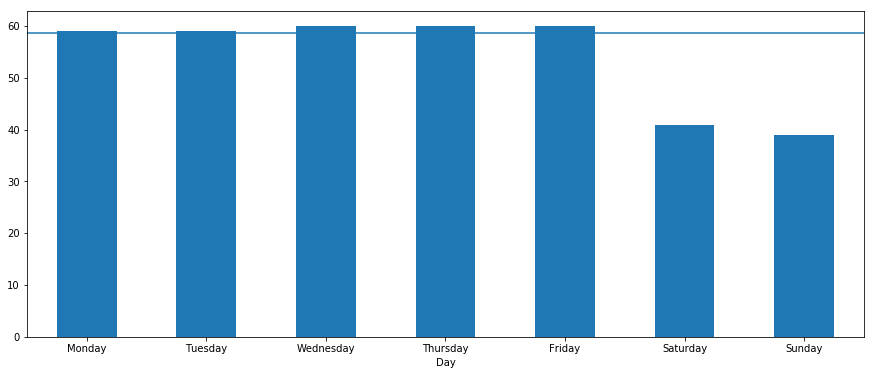

time: 139 ms


In [29]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  Weekdays at median or above, slight increase as the week goes on.  A good third or so quieter on weekends, more pronounced on Sunday.

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

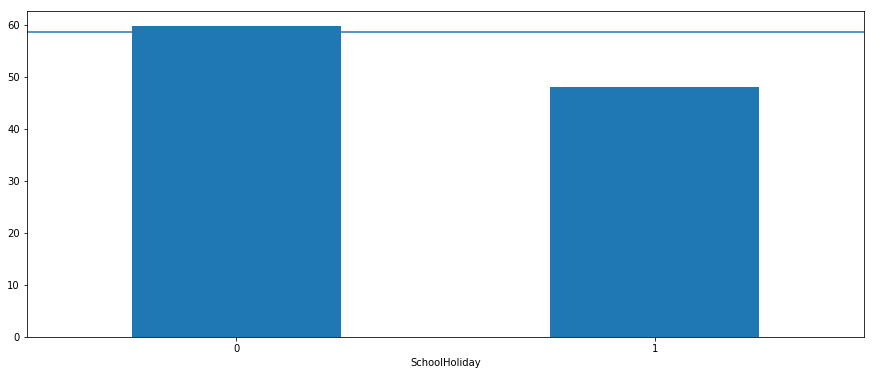

time: 122 ms


In [30]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

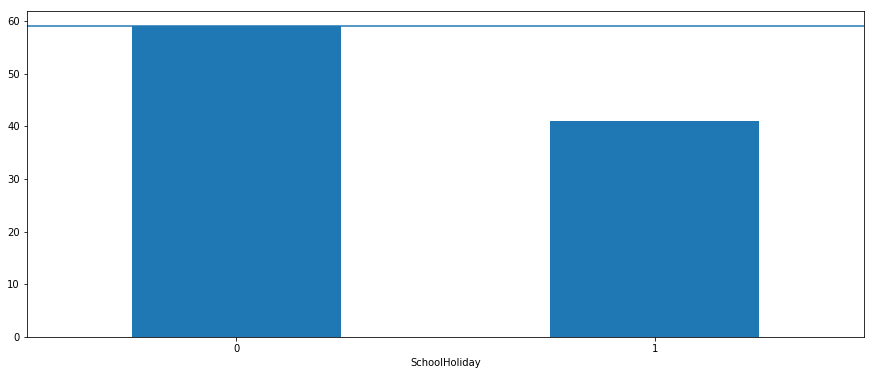

time: 121 ms


In [31]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [32]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,188,0.666667,18.0,45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,183,0.000000,14.5,71,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,183,1.866211,21.5,63,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,181,0.000000,17.5,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,181,0.600098,21.5,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,181,0.000000,6.0,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,181,1.533203,18.5,64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,180,0.366699,5.0,64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,180,0.000000,6.0,64,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,180,1.033203,22.0,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 88 ms


In [33]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 2 ms


In [34]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [35]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 4 ms


### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [36]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 11 ms


In [37]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.300310161012
time: 4 ms


In [38]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 15.6095857914
The mean absolute percentage error is 26.5584850909
time: 4 ms


In [39]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 12.5668483581
The median absolute percentage error is 21.2997429798
time: 5 ms


### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [40]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

The R-squared value of the Linear Regression model is 0.278933572588
time: 5 ms


In [41]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 16.1875357672
The mean absolute percentage error is 27.5418216138
time: 4 ms


In [42]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 13.1084709938
The median absolute percentage error is 22.2177474471
time: 4 ms


### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [43]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 4.41 s


In [44]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.12427537711
time: 3.01 s


In [45]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 16.925976852
The mean absolute percentage error is 28.7982211624
time: 3 ms


In [46]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 15.457844812
The median absolute percentage error is 26.1997369696
time: 3 ms


### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [47]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

The R-squared value of the SVR with RBF Kernel model is 0.106710716945
time: 1.29 s


In [48]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage error is", (((svr_rbf_maea)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 17.6392621131
The mean absolute percentage error is 30.0118200513
time: 3 ms


In [49]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage error is", (((svr_rbf_mdaea)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 16.0782926213
The median absolute percentage error is 27.251343426
time: 3 ms


### 3di Gradient Boosting Regression model - training - default parameters

In [50]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 411 ms


In [51]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
Day_Sunday 	 0.0942494843901
Day_Saturday 	 0.087224972932
WindSpeed 	 0.0693819825023
HF_23 	 0.0606159512444
HF_21 	 0.0591524930828
Rain 	 0.0575102234361
HF_17 	 0.0562153880591
SchoolHoliday 	 0.0545778315536
HF_22 	 0.0513732198637
HF_20 	 0.0493377104664
HF_6 	 0.0471666008632
HF_7 	 0.0363799706161
HF_8 	 0.0329452194643
HF_9 	 0.0322296056399
Day_Tuesday 	 0.0321311187333
JPID_length 	 0.0313606708881
HF_16 	 0.0301606602344
Day_Monday 	 0.0276485026696
HF_19 	 0.0177152901876
HF_11 	 0.0171022324659
XBuses 	 0.0157522390501
Day_Thursday 	 0.0125511618941
HF_15 	 0.0125052185392
HF_12 	 0.00728407808187
Day_Wednesday 	 0.00408794361719
HF_18 	 0.0018397237733
HF_14 	 0.000833376575989
HF_10 	 0.000667129175546
HF_13 	 0.0
time: 67 ms


In [52]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.335538808275
time: 14 ms


In [53]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 15.0780224017
The mean absolute percentage error is 25.6540717036
time: 3 ms


In [54]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 11.7180872322
The median absolute percentage error is 19.8611648003
time: 3 ms


### 3dii Gradient Boosting Regression model - - testing - default parameters

In [55]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.296558313524
time: 9 ms


In [56]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 15.8833577293
The mean absolute percentage error is 27.024286556
time: 2 ms


In [57]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 12.66842704
The median absolute percentage error is 21.4719102373
time: 3 ms


### 3ei Random Forest Regression model (all default) - training - default parameters

In [58]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 116 ms


In [59]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.189842700926
JPID_length 	 0.149160976264
HF_17 	 0.0809826213155
Day_Sunday 	 0.0741750687743
Day_Saturday 	 0.0571909093761
HF_8 	 0.0553454427953
Rain 	 0.0537792783151
HF_23 	 0.0367025699736
SchoolHoliday 	 0.0358665704872
Day_Thursday 	 0.0250473658459
HF_21 	 0.0248441782431
HF_22 	 0.0231325529234
HF_9 	 0.0219137531101
Day_Wednesday 	 0.0216746366265
Day_Tuesday 	 0.0183852790704
HF_16 	 0.0179744469023
HF_20 	 0.0162463902714
Day_Monday 	 0.0146605830017
XBuses 	 0.0143591537645
HF_6 	 0.00985177235992
HF_19 	 0.00850753453767
HF_11 	 0.00767890229729
HF_7 	 0.00730302005028
HF_15 	 0.00644047763428
HF_14 	 0.00611580551462
HF_10 	 0.00595007004161
HF_12 	 0.0057216840882
HF_13 	 0.00557478004501
HF_18 	 0.00557147544505
time: 3.05 s


In [60]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.558028172332
time: 106 ms


In [61]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 12.123278923
The mean absolute percentage error is 20.6268075805
time: 2 ms


In [62]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 9.275
The median absolute percentage error is 15.7203389831
time: 4 ms


### 3eii Random Forest Regression model (all default) - testing - default parameters

In [63]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

The R-squared value of the Random Forest Regression model is 0.166861901147
time: 104 ms


In [64]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 17.3458551473
The mean absolute percentage error is 20.6268075805
time: 2 ms


In [65]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage error is", (((rfr_mdaea)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 13.8333166833
The median absolute percentage error is 23.4462994632
time: 6 ms


## 4 All models bar Linear Regression - parameter tuning with RandomizedSearchCV

### 4a SVR with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [66]:
svr = SVR()

# Parameter settings taken from:
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html
# https://www.quora.com/What-is-an-appropriate-grid-search-range-for-optimizing-the-parameter-epsilon-in-epsilon-support-vector-regression

C_range = 10. ** np.arange(-3, 7)
gamma_range = 10. ** np.arange(-5, 4)

param_svr = {'C': C_range,
            'gamma': gamma_range,
            'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}

time: 4 ms


In [67]:
svr_rsearch = RSCV(svr, param_distributions=param_svr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
svr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03,   1.00000e+04,
         1.00000e+05,   1.00000e+06]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error, greater_is_better=False),
          verbose=0)

time: 52min 36s


In [68]:
print("Best parameters set found:")
print(svr_rsearch.best_params_)

Best parameters set found:
{'gamma': 0.01, 'epsilon': 4, 'C': 1000.0}
time: 1e+03 µs


In [69]:
svr_train_MdAE = abs(svr_rsearch.best_score_)
svr_train_MdAPE = (svr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", svr_train_MdAE)
print ("Best MdAPE found is", str(round(svr_train_MdAPE, 3)) + "%")

Best MdAE found is 12.5644588935
Best MdAPE found is 21.296%
time: 3 ms


In [70]:
svr_rsearch_table = pd.DataFrame(svr_rsearch.cv_results_)
svr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
svr_rsearch_table = svr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_C', 'param_gamma', 'param_epsilon', 'mean_fit_time', 'mean_score_time']]
svr_rsearch_table.reset_index(inplace=True)
svr_rsearch_table = svr_rsearch_table.drop('index', axis=1)

print("Full ranked results for SVR RandomizedSearchCV:")
svr_rsearch_table

Full ranked results for SVR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_C,param_gamma,param_epsilon,mean_fit_time,mean_score_time
0,1,-10.955785,-12.564459,1000,0.01,4,4.2958,0.3904
1,2,-12.417561,-12.579637,1e+06,1e-05,4,6.3896,0.3840
2,3,-12.493252,-12.769714,10,0.01,4,2.4652,0.3846
3,4,-11.728082,-13.779879,1000,0.01,1,5.2090,0.4480
4,5,-7.560232,-13.884069,100000,0.01,4,280.9950,0.4042
5,6,-14.086964,-14.164944,1000,0.0001,0.1,3.0854,0.4860
6,7,-7.008064,-14.591259,10,1,0,4.2620,0.5678
7,8,-14.279728,-14.936163,10000,0.001,0.5,7.3112,0.4738
8,9,-5.713002,-15.286902,10,100,2,4.6408,0.8666
9,10,-15.076459,-15.298698,100000,0.0001,1,8.4626,0.4406


time: 27 ms


In [71]:
# Running model on 30% test set

svr_test_pred = svr_rsearch.best_estimator_.predict(X_test)

svr_test_MdAE = metrics.median_absolute_error(y_test, svr_test_pred)
svr_test_MdAPE = (svr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", svr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(svr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 13.3156296283
MdAPE of best model on the test set is 22.569%
time: 1.03 s


### 4b Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [72]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(5, 8),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.6)}

time: 5 ms


In [73]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000027066860>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000027066F28>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026FEC8D0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000270A23C8>, 'learning_rate': <scipy.stats._distn_inf

time: 25min


In [74]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.050399050069222774, 'max_depth': 6, 'min_samples_leaf': 67, 'min_samples_split': 896, 'n_estimators': 2817}
time: 1e+03 µs


In [75]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 11.8493611576
Best MdAPE found is 20.084%
time: 4 ms


In [76]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-10.913238,-11.849361,2817,6,67,896,0.0503991,24.3946,0.0996
1,2,-11.214578,-11.865289,4016,5,35,701,0.0158757,31.0820,0.1260
2,3,-11.246981,-11.923245,317,5,6,635,0.0975036,2.4556,0.0100
3,4,-11.078948,-11.924764,1581,5,40,773,0.058657,11.9538,0.0482
4,5,-11.217372,-11.943061,233,6,75,650,0.187932,2.1518,0.0094
5,6,-10.961955,-11.954288,3933,5,87,905,0.154186,25.9684,0.1090
6,7,-10.776700,-12.003969,2458,6,10,472,0.0553537,23.2956,0.0904
7,8,-10.799531,-12.104051,3021,6,98,784,0.180607,24.1918,0.0990
8,9,-10.829357,-12.107630,362,7,73,655,0.266599,3.8552,0.0154
9,10,-11.180780,-12.109148,1460,7,87,316,0.0334125,15.6344,0.0648


time: 34 ms


In [77]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 12.3573243221
MdAPE of best model on the test set is 20.945%
time: 219 ms


### 4c Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [78]:
rfr = RFR()

param_rfr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 8),
            'min_samples_leaf': stats.randint(1, 20),
            'min_samples_split': stats.randint(1.0, 100)}

time: 4 ms


In [79]:
rfr_rsearch = RSCV(rfr, param_distributions=param_rfr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
rfr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029558F28>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029565828>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029565978>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029565B00>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          sco

time: 15min 11s


In [80]:
print("Best parameters set found:")
print(rfr_rsearch.best_params_)

Best parameters set found:
{'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 4738}
time: 1e+03 µs


In [81]:
rfr_train_MdAE = abs(rfr_rsearch.best_score_)
rfr_train_MdAPE = (rfr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", rfr_train_MdAE)
print ("Best MdAPE found is", str(round(rfr_train_MdAPE, 3)) + "%")

Best MdAE found is 14.7250870249
Best MdAPE found is 24.958%
time: 3 ms


In [82]:
rfr_rsearch_table = pd.DataFrame(rfr_rsearch.cv_results_)
rfr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
rfr_rsearch_table = rfr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_fit_time', 'mean_score_time']]
rfr_rsearch_table.reset_index(inplace=True)
rfr_rsearch_table = rfr_rsearch_table.drop('index', axis=1)

print("Full ranked results for rfr RandomizedSearchCV:")
rfr_rsearch_table

Full ranked results for rfr RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time
0,1,-14.143992,-14.725087,4738,7,3,12,29.6938,0.4878
1,2,-14.323841,-14.755553,239,7,7,29,1.4962,0.0256
2,3,-14.269148,-14.767467,4256,7,6,27,26.6516,0.4552
3,4,-14.451494,-14.791280,3761,7,9,97,22.9360,0.3572
4,5,-14.440541,-14.830789,1596,7,7,71,9.9900,0.1544
5,6,-14.432099,-14.834921,3246,7,2,91,20.5842,0.3084
6,7,-14.599833,-14.976576,3344,7,19,41,20.3480,0.3586
7,8,-15.298718,-15.408426,351,6,15,37,1.9212,0.0302
8,9,-15.418292,-15.468612,3837,6,17,48,21.1640,0.3260
9,10,-15.350169,-15.481537,1130,6,10,43,6.3562,0.0974


time: 27 ms


In [83]:
# Running model on 30% test set

rfr_test_pred = rfr_rsearch.best_estimator_.predict(X_test)

rfr_test_MdAE = metrics.median_absolute_error(y_test, rfr_test_pred)
rfr_test_MdAPE = (rfr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", rfr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(rfr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 15.4517428567
MdAPE of best model on the test set is 26.189%
time: 810 ms
